# AI Ethics Project - STARTER

Personalization is a central aspect of many core AI systems. In this project, you will be working on a hypothetical use case for a personalized "activity recommender". The use case has a medium ethical AI risk level and involves a synthetic dataset.

IDOOU is a mobile app users can leverage to get recommendations on activities they can take in a given area, like “visiting a movie theater”, “visiting a park”, “sightseeing”, “hiking”, or “visiting a library”.


**Problem statement**:

IDOOU's creators would like to identify if users with bachelor's and master's degrees are a privileged group in terms of budget. In other words, do users with higher education credentials beyond high school have a budget >= $300 compared to users of the app who graduated from high school? 

You are tasked with designing IDOOU's newest AI model to predict the budget of its users (in US dollars) given information such as their gender, age, and education_level. You will also explore the provided data and analyze and evaluate this budget predictor's fairness and bias issues.


**Key points**:

- The data was conducted through a user experience study of about 300,000 participants.
- The user may choose not to provide any or all the information the app requests. The training data also reflects this.
- Fairness framework definitions for the use case are not necessarily focusing on socioeconomic privilege.

In [1]:
%pip install aif360
%pip install tensorflow
%pip install jinja2
%pip install fairlearn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 259 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 30.0 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 90.0 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 35.6 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 56.2 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 88.4 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 33.0 MB/s eta 0:00:01
     |████████████████████████████████| 307 kB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 54.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 75.6 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 29.9 MB/s eta 0:00:01
     |██████████████████

**Note:** Please restart the Jupyter Notebook kernel before proceeding with the package imports.

In [2]:
#You may add additional imports as needed
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from sklearn.tree import DecisionTreeClassifier
from aif360.algorithms.postprocessing import RejectOptionClassification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

/Users/xabier_laibarra/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
pip install 'aif360[inFairness]'


In [3]:
#Load the dataset for this project
act_rec_dataset = pd.read_csv('udacity_ai_ethics_project_data.csv')
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


## Step 1: Data Pre-Processing and Evaluation

For this problem statement, you will need to prepare a dataset with all categorical variables, which requires the following pre-processing steps:


- Remove the NA values from the dataset
- Convert Age and Budget (in dollars) to categorical columns with the following binning:

> Bins for Age: 18-24, 25-44, 45-65, 66-92

> Bins for Budget: >=300, <300

In [4]:
#FILL IN - the below dataframe should be pre-processed
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


In [5]:
act_rec_dataset.shape

(300000, 6)

In [6]:
act_rec_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Budget (in dollars)   300000 non-null  float64
 1   Age                   300000 non-null  float64
 2   Gender                250201 non-null  object 
 3   Education_Level       256408 non-null  object 
 4   With children?        216151 non-null  float64
 5   Recommended_Activity  300000 non-null  object 
dtypes: float64(3), object(3)
memory usage: 13.7+ MB


In [7]:
# Remove NA values from the datase
cols = act_rec_dataset.columns
act_rec_dataset_nonan = act_rec_dataset.dropna(subset=cols)

In [8]:
act_rec_dataset_nonan.shape

(156317, 6)

In [9]:
# Function to classify persons based on the budget
def budget_bins(row):
    if row['Budget (in dollars)']<300:
        return '<300'
    else:
        return '>=300'

In [10]:
act_rec_dataset_nonan['Age'].describe()

count    156317.000000
mean         32.357248
std          16.399829
min          18.000000
25%          21.000000
50%          25.000000
75%          39.000000
max          91.000000
Name: Age, dtype: float64

In [11]:
# Generate a column to classify the people based on their budget
act_rec_dataset_nonan['budget_bin'] = act_rec_dataset_nonan.apply(budget_bins, axis=1)
act_rec_dataset_nonan.head()

/var/folders/9b/t0pcm1894xl71s979rgz9z240000gn/T/ipykernel_7610/286553676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_rec_dataset_nonan['budget_bin'] = act_rec_dataset_nonan.apply(budget_bins, axis=1)


,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity,budget_bin
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV,>=300
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater,<300
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library,>=300
5,3335.0,35.0,Male,Bachelor’s Degree,1.0,Play: Go shopping,>=300
6,4044.0,42.0,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing,>=300


In [12]:
# Function to generate age bins
# 18-24, 25-44, 45-65, 66-92
def age_bins(row):
    if row['Age']<24:
        return '18-24'
    
    elif row['Age']>24 and row['Age']<=44 :
        return '25-44'
    
    elif row['Age']>44 and row['Age']<=65 :
        return '45-65'
    
    else:
        return '66-92'


In [13]:
# Generate age_bin column
act_rec_dataset_nonan['age_bin'] = act_rec_dataset_nonan.apply(age_bins, axis=1)

/var/folders/9b/t0pcm1894xl71s979rgz9z240000gn/T/ipykernel_7610/627671242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_rec_dataset_nonan['age_bin'] = act_rec_dataset_nonan.apply(age_bins, axis=1)


In [14]:
act_rec_dataset_nonan.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity,budget_bin,age_bin
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV,>=300,25-44
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater,<300,18-24
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library,>=300,66-92
5,3335.0,35.0,Male,Bachelor’s Degree,1.0,Play: Go shopping,>=300,25-44
6,4044.0,42.0,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing,>=300,25-44


### Evaluate bias issues in the dataset

Next, let's take a look at potential hints of data bias in the variables, particularly the "Gender", "Age", and "Education" variables.

Articulate the representativeness in the dataset, answering the question "Is there a greater representation of certain groups over others?"

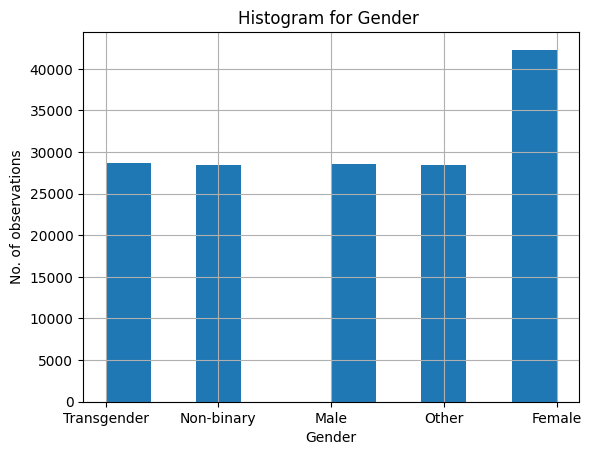

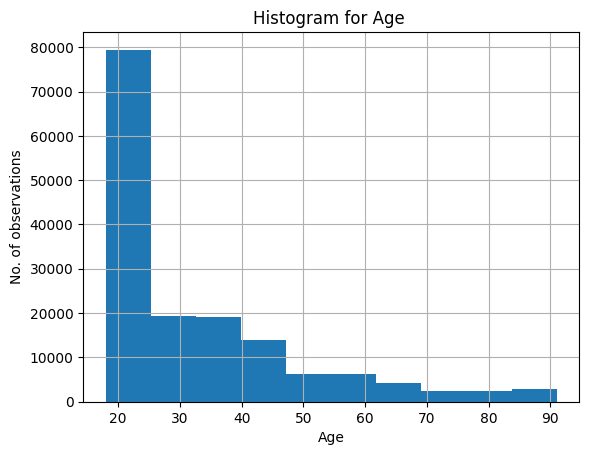

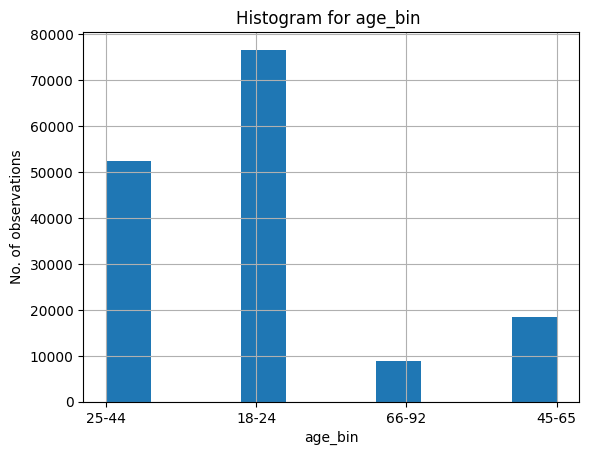

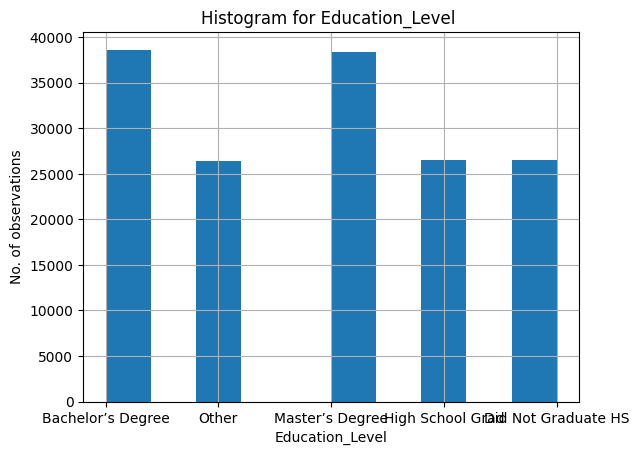

In [15]:
#FILL IN
#Generate visualizations to understand the representativeness of the dataset, so we can see the distributions by dimension.

import matplotlib.pyplot as plt
import seaborn as sns

cols_rep = ['Gender', 'Age','age_bin', 'Education_Level']

for i in cols_rep:
    df_var = act_rec_dataset_nonan[i]
    
    plt.xlabel('{}'.format(i))
    plt.ylabel('No. of observations')
    plt.title('Histogram for {} '.format(i))
    df_var.hist()

    plt.show()

Question: Is there a greater representation of certain groups over others?

- Regarding the gender, we can see that "female" are more represented than the rest, which are equally represented.

- Attending to the "age" the most represented group is "18-24" one but "25-44" is also highly represented compared to the population older than 44 years.

- Finally, the University degrees are the most represented ones, hence, bachelor and master degrees, which are equally represented.

Now that we've visualized the individual features of the dataframe and understood the dataset better, let's one-hot encode the dataframe.

In [18]:
#FILL IN: 
#The variable act_rec_dataset should contain the one-hot encoded variables
act_rec_dataset_nonan.columns

Index(['Budget (in dollars)', 'Age', 'Gender', 'Education_Level',
       'With children?', 'Recommended_Activity', 'budget_bin', 'age_bin'],
      dtype='object')

In [16]:
# Columns that should be one hot encoded ('With_children?' column is already one hot encoded):
one_hot_cols = ['Gender', 'Education_Level', 'Recommended_Activity', 'budget_bin', 'age_bin']
# df1_one_hot dataframe keeps the columns that do not require one hot encoding.
# df2_one_hot contains the one hot encoded variables, columns.
df1_one_hot = act_rec_dataset_nonan.drop(columns=['Budget (in dollars)', 'Age', 'Gender', 'Education_Level', 'Recommended_Activity', 'budget_bin', 'age_bin'], axis=1) 
df_to_one_hot = act_rec_dataset_nonan[ one_hot_cols]
df2_one_hot = pd.get_dummies(df_to_one_hot[one_hot_cols], dtype='int')
df_one_hot_final = df1_one_hot.join(df2_one_hot)

In [17]:
df_one_hot_final.head(10)

,With children?,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,Education_Level_Bachelor’s Degree,Education_Level_Did Not Graduate HS,Education_Level_High School Grad,Education_Level_Master’s Degree,...,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV,budget_bin_<300,budget_bin_>=300,age_bin_18-24,age_bin_25-44,age_bin_45-65,age_bin_66-92
0,0.0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3,0.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,1.0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
5,1.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
6,0.0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
8,1.0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
9,1.0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
11,1.0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
13,0.0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
17,1.0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0


Visualize the interactions between the categorical variables. Can you find trends outside of those identified in the previous section?

**Hint**: Use a multicollinearity matrix.

<Axes: >

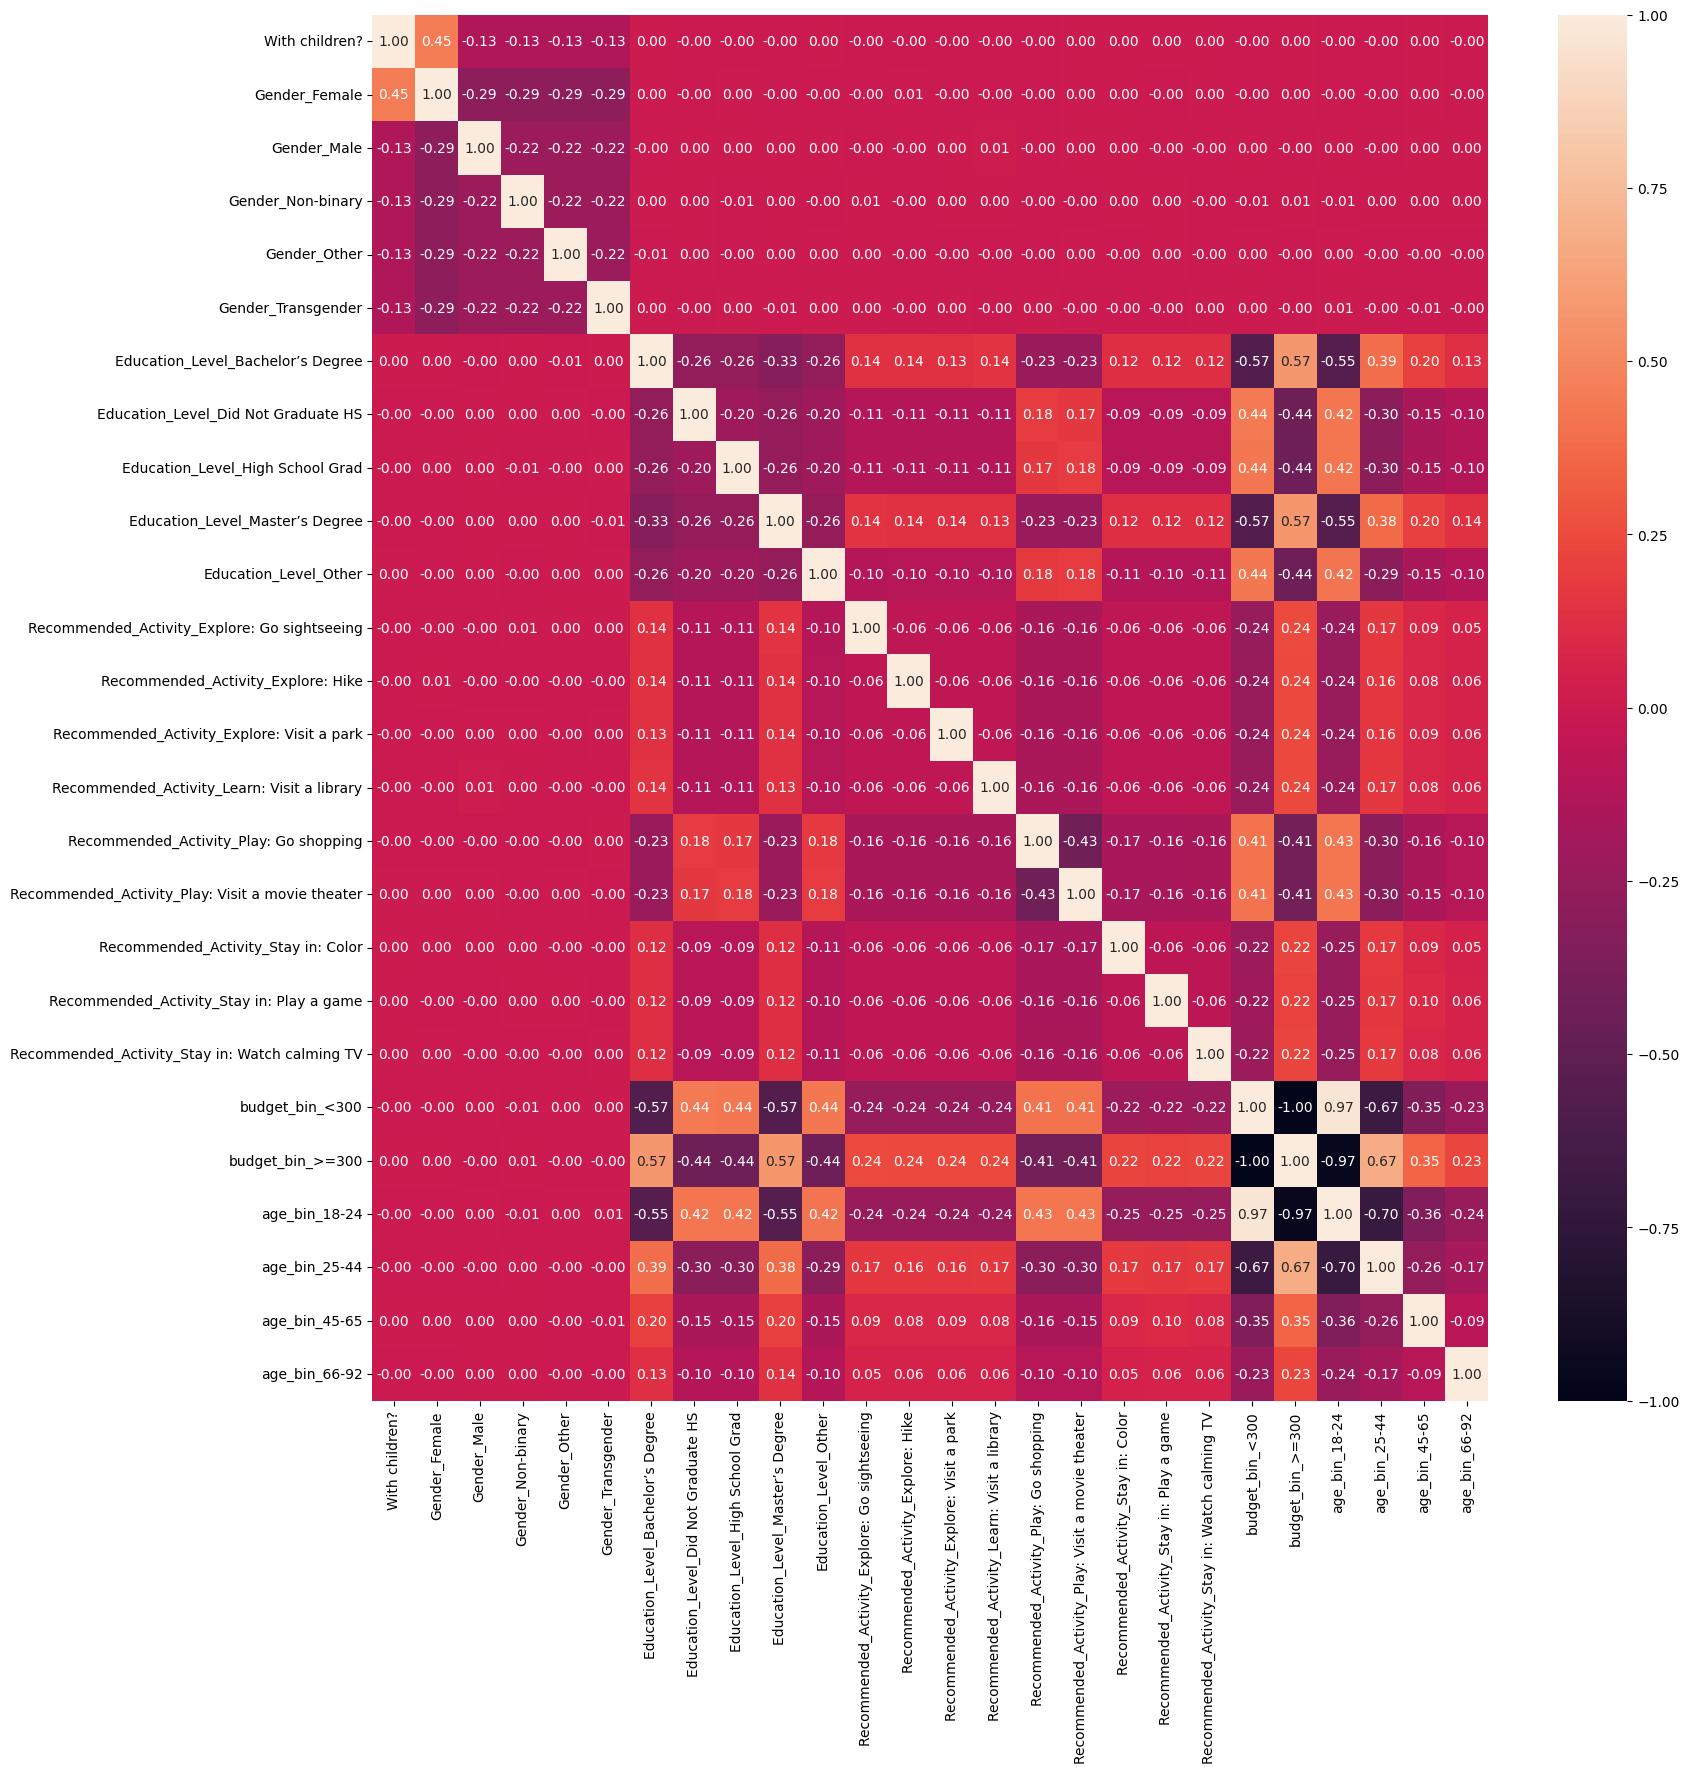

In [ ]:
#FILL IN
# Correlation matrix needs to be interpreted
import seaborn as sns
corr = df_one_hot_final.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,  fmt = '.2f')


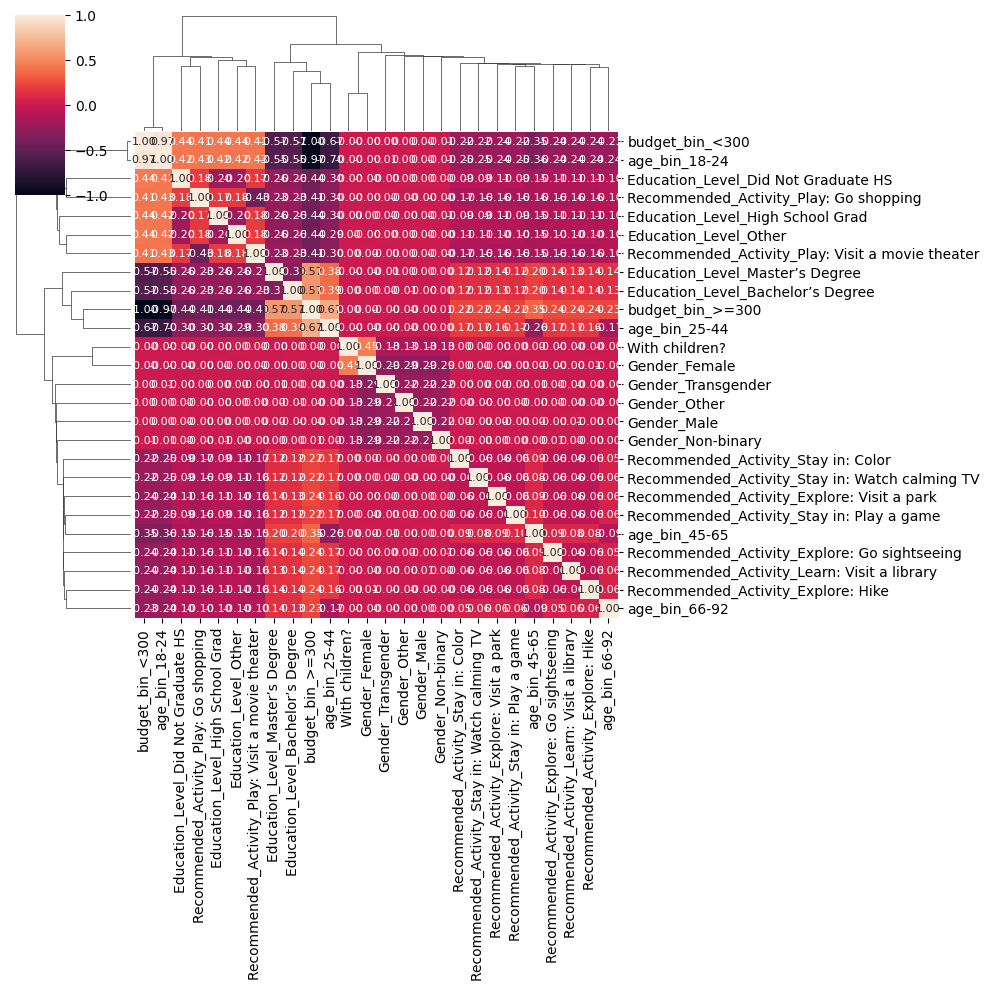

In [35]:
corr2 = df_one_hot_final.corr()
sns.clustermap(corr2, 
            xticklabels=corr2.columns.values,
            yticklabels=corr2.columns.values, annot=True,annot_kws={'size':8}, fmt = '.2f')
#plt.figure(figsize=(18, 18))

Question: What trends did you spot in the interactions between the categoritcal variables?

- Budget is very related to age and educational level. It has a positive correlation for older and more educated people, hence, the budget increases with both of them and a negative correlations for younger and less educated people.
- The recommended activity is also correlated to the budget and to the educational level.

For the purposes of this project, we will drop the following elements from the dataframe:

- Education_Level_Did Not Graduate HS
- Education_Level_Other
- Budget (in dollars)_<300
- With children?

In [36]:
#We drop certain variables that are highly correlated and irrelevant
act_rec_dataset = df_one_hot_final.drop(columns=['Education_Level_Did Not Graduate HS', 'Education_Level_Other', 'budget_bin_<300', 'With children?'])
act_rec_dataset.head()

,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,Education_Level_Bachelor’s Degree,Education_Level_High School Grad,Education_Level_Master’s Degree,Recommended_Activity_Explore: Go sightseeing,Recommended_Activity_Explore: Hike,...,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV,budget_bin_>=300,age_bin_18-24,age_bin_25-44,age_bin_45-65,age_bin_66-92
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
5,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
6,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0


### Evaluate fairness issues

Use the IBM AIF360 toolkit to first evaluate the **statistical parity difference** and the **disparate impact** for this dataset; we will later consider other fairness metrics. Interpret your findings - is there bias in the proposed problem statement? If yes, what group is benefitting?

**Hint**: Use the BinaryLabelDataset and the BinaryLabelDatasetMetric functions for the fairness evaluation. The reported Statistical Parity Difference may be within -0.64 and -0.55, and the Disparate impact value may be within 0.136 and 0.0150.

In [24]:
act_rec_dataset.columns

Index(['Gender_Female', 'Gender_Male', 'Gender_Non-binary', 'Gender_Other',
       'Gender_Transgender', 'Education_Level_Bachelor’s Degree',
       'Education_Level_High School Grad', 'Education_Level_Master’s Degree',
       'Recommended_Activity_Explore: Go sightseeing',
       'Recommended_Activity_Explore: Hike',
       'Recommended_Activity_Explore: Visit a park',
       'Recommended_Activity_Learn: Visit a library',
       'Recommended_Activity_Play: Go shopping',
       'Recommended_Activity_Play: Visit a movie theater',
       'Recommended_Activity_Stay in: Color',
       'Recommended_Activity_Stay in: Play a game',
       'Recommended_Activity_Stay in: Watch calming TV', 'budget_bin_>=300',
       'age_bin_18-24', 'age_bin_25-44', 'age_bin_45-65', 'age_bin_66-92'],
      dtype='object')

In [37]:
label_col = ['budget_bin_>=300']
cols_to_drop =['budget_bin_>=300','Recommended_Activity_Explore: Go sightseeing',
       'Recommended_Activity_Explore: Hike',
       'Recommended_Activity_Explore: Visit a park',
       'Recommended_Activity_Learn: Visit a library',
       'Recommended_Activity_Play: Go shopping',
       'Recommended_Activity_Play: Visit a movie theater',
       'Recommended_Activity_Stay in: Color',
       'Recommended_Activity_Stay in: Play a game',
       'Recommended_Activity_Stay in: Watch calming TV']
protected_attribute_names_cols = act_rec_dataset.drop(columns=cols_to_drop, axis=1).columns
protected_attribute_names_cols

Index(['Gender_Female', 'Gender_Male', 'Gender_Non-binary', 'Gender_Other',
       'Gender_Transgender', 'Education_Level_Bachelor’s Degree',
       'Education_Level_High School Grad', 'Education_Level_Master’s Degree',
       'age_bin_18-24', 'age_bin_25-44', 'age_bin_45-65', 'age_bin_66-92'],
      dtype='object')

In [38]:

binary_act_dataset = BinaryLabelDataset( favorable_label=1, unfavorable_label=0,  df = act_rec_dataset, label_names = label_col, 
                                        protected_attribute_names = protected_attribute_names_cols)



In [39]:
help(BinaryLabelDataset)

Help on class BinaryLabelDataset in module aif360.datasets.binary_label_dataset:

class BinaryLabelDataset(aif360.datasets.structured_dataset.StructuredDataset)
 |  BinaryLabelDataset(favorable_label=1.0, unfavorable_label=0.0, **kwargs)
 |  
 |  Base class for all structured datasets with binary labels.
 |  
 |  Method resolution order:
 |      BinaryLabelDataset
 |      aif360.datasets.structured_dataset.StructuredDataset
 |      aif360.datasets.dataset.Dataset
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, favorable_label=1.0, unfavorable_label=0.0, **kwargs)
 |      Args:
 |          favorable_label (float): Label value which is considered favorable
 |              (i.e. "positive").
 |          unfavorable_label (float): Label value which is considered
 |              unfavorable (i.e. "negative").
 |          **kwargs: StructuredDataset arguments.
 |  
 |  validate_dataset(self)
 |      Error checking and type validation.
 |      
 

In [40]:
help(BinaryLabelDatasetMetric)

Help on class BinaryLabelDatasetMetric in module aif360.metrics.binary_label_dataset_metric:

class BinaryLabelDatasetMetric(aif360.metrics.dataset_metric.DatasetMetric)
 |  BinaryLabelDatasetMetric(dataset, unprivileged_groups=None, privileged_groups=None)
 |  
 |  Class for computing metrics based on a single
 |  :obj:`~aif360.datasets.BinaryLabelDataset`.
 |  
 |  Method resolution order:
 |      BinaryLabelDatasetMetric
 |      aif360.metrics.dataset_metric.DatasetMetric
 |      aif360.metrics.metric.Metric
 |      abc.ApplyDecorator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset, unprivileged_groups=None, privileged_groups=None)
 |      Args:
 |          dataset (BinaryLabelDataset): A BinaryLabelDataset.
 |          privileged_groups (list(dict)): Privileged groups. Format is a list
 |              of `dicts` where the keys are `protected_attribute_names` and
 |              the values are values in `protected_attributes`. Each `dict`
 |   

In [41]:
privileged_group = [{'Education_Level_Master’s Degree':1}]
unprivileged_group = [{'Education_Level_Master’s Degree':0}]
orig_metric_act_dataset = BinaryLabelDatasetMetric(binary_act_dataset, unprivileged_groups = unprivileged_group  , privileged_groups = privileged_group)

print("Statistical Parity Difference ={}".format(orig_metric_act_dataset.mean_difference()))
print("Disparate impact ={}".format(orig_metric_act_dataset.disparate_impact()))

Statistical Parity Difference =-0.6618938372367
Disparate impact =0.3331348757691641


Question: Evaluate the fairness metrics. What are your findings? Is there bias in the proposed problem statement? If yes, what group is benefitting?

**Regarding the statistical parity difference, we can see that the value is negative, so the privileged group is being benefitted. On the other hand, as the diparate impact ratio has a positive value, the unprivileged group has a higher benefit. However, as this last value is small (less than 0,8 or even less than 1) a potential bias against the unprivileged group could also be considered.**

## Step 2: Investigate an ML model on the problematic Dataset

For this project, we are using a train-test-validation split.

You have available boilerplate for training 2 ML models on this dataset - you will need to train these models and use the methods we covered in this course to identify and evaluate their performance (**using the accuracy metric and confusion matrix**).

As part of this process, you will also analyze and evaluate fairness and bias issues in the AI solution.

In [42]:
(orig_train,
 orig_validate,
 orig_test) = binary_act_dataset.split([0.5, 0.8], shuffle=True)

In [43]:
#Source: Helper code snippet from https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    y_val_pred_prob = model.predict_proba(dataset.features)
    y_val_pred = model.predict(dataset.features)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_group,
                privileged_groups=privileged_group)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs, y_val_pred

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

### 2.1. GNB model.

In [44]:
GNB_model = GaussianNB().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, gnb_pred = test(dataset=orig_test,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.9866
Corresponding average odds difference value: -0.0144
Corresponding statistical parity difference value: -0.6474
Corresponding equal opportunity difference value: -0.0042
Corresponding Theil index value: 0.0057


In [45]:
#FILL IN
#Evaluate the accuracy of the model

accuracy = accuracy_score(y_true=orig_test.labels.ravel(), y_pred=gnb_pred)
print(accuracy)

0.9864700614124872


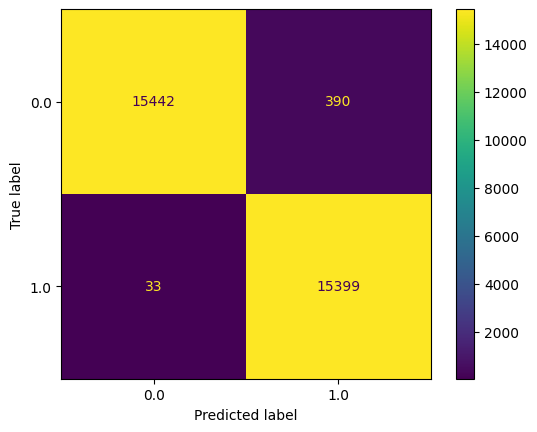

In [46]:
#Visualize the performance (confusion matrix) of the model
ConfusionMatrixDisplay.from_predictions(orig_test.labels.ravel(), y_pred=gnb_pred)

### 2.2. Logistic Regression model.

In [47]:
LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights)

In [48]:
#Load the Logistic Regression model
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_pred = test(dataset=orig_test,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3200
Best balanced accuracy: 0.9957
Corresponding average odds difference value: -0.0329
Corresponding statistical parity difference value: -0.6679
Corresponding equal opportunity difference value: -0.0167
Corresponding Theil index value: 0.0042


In [49]:
#FILL IN
#Evaluate the accuracy of the model

accuracy_lr = accuracy_score(y_true=orig_test.labels.ravel(), y_pred=lr_pred)
print(accuracy_lr)


0.9957139201637666


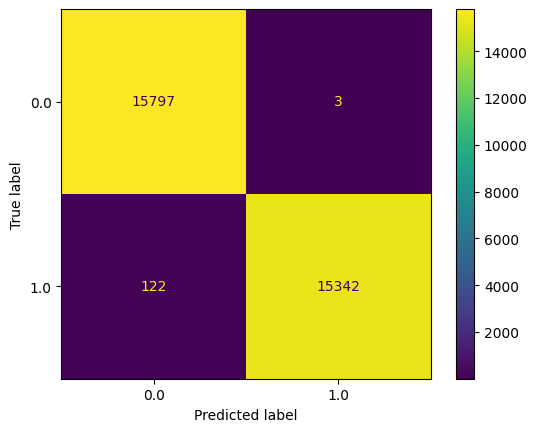

In [ ]:
#Visualize the performance (confusion matrix) of the model
# Results need to be interpreted

ConfusionMatrixDisplay.from_predictions(orig_test.labels.ravel(), y_pred=lr_pred)

### 2.3. Analysis of results.

In [39]:
#Fill IN
#Compare the model accuracy on test dataset either in a bar plot or table format

In [40]:
#FILL IN Optional
#Compare the fairness metrics on test dataset

Question: Interpret and compare the results of each model. What do you find in the false negative and false positive of each model? What about the fairness metrics?

**Your answer:**

Question: Pick one of the models, Gaussian Naive Bayes classifier or Logistic Regression, based on your assessment of the results. Briefly explain your reason.

**Your answer:**

## Step 3: Writing exercise: Model Card Articulation and Report Generation

Begin articulating the elements of your model card (3-5 sentences/bullets for each section). Please delineate bullet points using two hyphens, as show in the example below.

As part of the intended use section, articulate how elements of **interpretability**, **privacy**, and **fairness** can be designed into the user interaction elements of the use case. **Hint:** Should IDOOU prompt the user to check whether the budget predictor model's results are correct?

In [41]:
model_details = """
-- Budget Predicter AI is a model that ...
-- ...
-- ...
"""
intended_use = """
-- 
-- 
-- 
"""
factors = """
-- 
-- 
-- 
"""

Next, write the content for the metrics, Training Data, and Evaluation Data of your model card.

In [42]:
metrics = """
-- 
-- 
-- 
"""
training_data = """
-- 
"""
eval_data = """
-- 
"""

## Step 4: Use Interpretability mechanisms

Use an interpretability mechanism(s) of your choice, e.g. permutation importance, LIME, etc., to understand the feature importance and model's predictions on the test dataset. **Visualize** and note down the key contributing factors - you will later incorporate this in your model card.

In [43]:
#FILL IN
#Use an interpretability mechanism to investigate the AI model you chose

Question: Which interpretability mechanism did you choose? What are the key contributing factors?

**Your answer:**


## Step 5: Apply a bias mitigation strategy

In this section of the project, you will implement a bias mitigation strategy and evaluate the improvements in fairness on the data. Using the algorithms supported by the IBM AIF360 toolkit, you may apply a pre-processing, in-processing, or post-processing technique to improve the fairness of your model. Optionally, you may also consider combining multiple techniques.

**Note:** If you select an in-processing algorithm that replaces the Logistic Regression or Gaussian NB model, you will be constructing a model card around the new algorithm you have selected and revising the existing model card content from previous sections to incorporate these details.

In [44]:
#FILL IN - implement bias mitigation strategy

In [45]:
#FILL IN
#Obtain the new metric values after applying your bias mitigation strategy
describe_metrics(..., ...)

TypeError: 'ellipsis' object is not subscriptable

**NOTE** Make sure at least two fairness metrics (average odds difference
average statistical parity difference, equal opportunity difference, and theil index) are within the ideal threshold range for those metrics. A slightly higher benefit for the privileged group may still be seen, which is ok.

Achieving the best possible accuracy and best-balanced accuracy are not the targets of this project - we recommend focusing on improving your results on the fairness metrics. It is recommended to have your balanced accuracy between 85%-100% but not required.

**IMPORTANT! If less than two fairness metrics are within the ideal range, re-work on your strategy.**

Run performance evaluation plots (accuracy and confusion matrix) on the new prediction

In [ ]:
### FILL IN

Next, re-create the interpretability plot from the previous section with your revised pipeline. 

In [ ]:
### FILL IN

Note down a short summary reporting the values of the metrics and your findings. This will be the quantitative analysis section of the model card.
- Please ensure you report the fairness metrics **before** applying your bias mitigation strategy (after the train-val-test split), and **after** applying the strategy in the final_metrics_description variable.
- Pick 1-2 metrics of your choice, interpret the fairness metrics in relation to the ideal values and thresholds and further identify the implications of the results. 

In [ ]:
final_metrics_description = """
--
--Before...
--After...
--
"""

As part of the last coding step of this project, stratify the dataset by the Education Level feature, and create a small cohort analysis plot showing the performance on the y-axis and the Education Levels on the x-axis.

In [ ]:
##Fill in

**Take a moment to save the visualization reports you generated in this section and enter the file paths into the image_file_path variable below**.

In [ ]:
#FILL IN - save all visualization plots 
#from the "Apply a bias mitigation strategy" section
#plt.savefig('file_name.png')

#Replace the REPLACE_FILE_NAME placeholder with the image paths
#of the visualizations you have generated for the model card
image_file_path ="""
  <img src="REPLACE_FILE_NAME.png"><br/>
  <img src="REPLACE_FILE_NAME.png"><br/>
  <img src="REPLACE_FILE_NAME.png"><br/>
"""

**Optional**: You may choose to create a cohort analysis plot showing the fairness metric values on the y-axis and the Education Levels on the x-axis.

In [ ]:
#Optional save image for the fairness corhort analysis
#plt.savefig('images/optional_fairness_cohort_analysis') 

## Step 6: Articulate the ethical implications

Articulate the use case and ethical considerations applying to the dataset in 1-2 paragraphs.

**Hints:** 
 
- Think about the limitations of the dataset, potential biases that could be introduced into the use case, and the strengths and weaknesses of your ML model.
- Ethical Considerations:
 - Human-in-the-loop considerations: Can users control aspects of the model and inspect the features? If so, briefly describe how?
 - Describe the limitations and types of bias present in the data
 - Describe the failures of the ML model
 - It must include a section on any risk mitigation strategies you applied.
 - Describe Potential harms
 - It must include key contributing factors you found from your interpretability study, both before and after applying the bias mitigation strategy.

- Caveats and Recommendations
 - Potential lack of inclusiveness in the dataset
 - Predisposition of the model to false positives and/or negatives
 - It must also include 1-2 sentences on the further ethical AI analyses you would apply if given more time beyond this project.

In [ ]:
#FILL IN
ethical_considerations="""
-- 
-- 
-- 
"""
caveats_and_recommendations="""
-- 
-- 
-- 
-- Further ethical AI analyses I would apply beyond this project:
"""

- Business consequences
 - Potential positive impact of the IDOOU Budget Predicter AI
 - Reasons why users may lose trust in the application, and loss of revenue and brand reputation might occur to the organization

In [ ]:
business_consequences="""

-- Positive Impact:

-- Negative Impact:
"""

## Document the solution in a model card

You're at the finish line! Run the last few blocks of code to generate a simple html file with your model card content and the visualizations you generated for the final version of your model.

Make sure to open the html file and check that it is reflective of your model card content before submitting.

Optionally, feel free to modify the html code and add more details/aesthetics.

In [ ]:
html_code = f"""
<html>
  <head>
  </head>
  <body>
  <center><h1>Model Card - IDOOU AI Budget Predicter</h1></center>
  <h2>Model Details</h2>
  {model_details}
  <h2>Intended Use</h2>
  {intended_use}
  <h2>Factors</h2>
  {factors}
  <h2>Metrics</h2>
  {metrics}
  <h2> Training Data </h2>
  {training_data}
  <h2> Evaluation Data </h2>
  {eval_data}
  <h2>Quantitative Analysis</h2>
  {final_metrics_description}
  
  <br/><br/><b>Results of the AI model after applying the bias mitigation strategy</b><br/>
  
  <center>
  {image_file_path}
  </center>

  <h2>Ethical Considerations</h2>
  {ethical_considerations}
  <h2>Caveats and Recommendations</h2>
  {caveats_and_recommendations}
  <h2>Business Consequences</h2>
  {business_consequences}
  </body>
</html>"""
html_code = html_code.replace('--', '<br>--')

In [ ]:
with open('model_card.html', 'w') as f:
    f.write(html_code)

Download and zip the .html report, the images you generated, and this Jupyter notebook, and you're ready for submission!